In [1]:
import os
import sys
import time 

import numpy as np
import cv2
from matplotlib import pyplot as plt
import importlib
import torch
import torchvision

from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

sys.path.append("../")

import config

from model_training import training_data_loader


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu_device = torch.device('cpu')

In [3]:
TRAINING_DIRS_1 = [
    '31_03_21__318__3or4_people/1/006__11_44_59',
    '31_03_21__318__3or4_people/1/007__11_48_59',
    '31_03_21__318__3or4_people/1/008__11_52_59',
    '31_03_21__318__3or4_people/1/009__11_57_00',
     ]

TRAINING_DIRS_2 = [
    '31_03_21__318__3or4_people/2/000__14_15_19',
    '31_03_21__318__3or4_people/2/001__14_19_19',
    '31_03_21__318__3or4_people/2/002__14_23_19',
    '31_03_21__318__3or4_people/2/003__14_27_20',
    '31_03_21__318__3or4_people/2/004__14_31_20',
    ]

TRAINING_DIRS_3 = [
    '31_03_21__318__3or4_people/2/010__14_55_20',
    '31_03_21__318__3or4_people/2/011__14_59_20',
    '31_03_21__318__3or4_people/2/012__15_03_21',
    '31_03_21__318__3or4_people/2/013__15_07_21',
    '31_03_21__318__3or4_people/2/014__15_11_21',
    '31_03_21__318__3or4_people/2/015__15_15_21',
    '31_03_21__318__3or4_people/2/016__15_19_21',
    ]

VALIDATION_DIRS_1 = [
    '31_03_21__318__3or4_people/2/005__14_35_20',
    '31_03_21__318__3or4_people/2/006__14_39_20',
    '31_03_21__318__3or4_people/2/007__14_43_20',
    '31_03_21__318__3or4_people/2/008__14_47_20',
    '31_03_21__318__3or4_people/2/009__14_51_20',
]


_training_data_1 = training_data_loader.load_data_for_labeled_batches(labeled_batch_dirs=TRAINING_DIRS_1)
_training_data_2 = training_data_loader.load_data_for_labeled_batches(labeled_batch_dirs=TRAINING_DIRS_2)
_training_data_3 = training_data_loader.load_data_for_labeled_batches(labeled_batch_dirs=TRAINING_DIRS_2)

_validation_data_1 = training_data_loader.load_data_for_labeled_batches(labeled_batch_dirs=VALIDATION_DIRS_1)

augmented_data_training = training_data_loader.AugmentedBatchesTrainingData()
augmented_data_training.add_training_batch(_training_data_1)
augmented_data_training.add_training_batch(_training_data_2)
augmented_data_training.add_training_batch(_training_data_3)

augmented_data_validation = training_data_loader.AugmentedBatchesTrainingData()
augmented_data_validation.add_training_batch(_validation_data_1)


In [4]:
augmented_data_training.print_stats()

AugmentedBatchesTrainingData with 12 BatchTrainingData batches.
Total number of frames after augmentation: 26364, with:
   4616 frames with 3 persons
   19712 frames with 2 persons
   1016 frames with 4 persons
   624 frames with 1 persons
   396 frames with 0 persons


In [5]:
augmented_data_validation.print_stats()

AugmentedBatchesTrainingData with 4 BatchTrainingData batches.
Total number of frames after augmentation: 9420, with:
   1824 frames with 2 persons
   6872 frames with 3 persons
   724 frames with 4 persons


In [6]:
NUMBER_OF_OUPUT_CLASSES = 2

def draw_airbrush_circle(img, centre, radius):
    for x in range(max(0, round(centre[0]-radius)), min(img.shape[0], round(centre[0]+radius+1))):
        for y in range(max(0, round(centre[1]-radius)), min(img.shape[1], round(centre[1]+radius+1))):
            point = (x, y)
            distance_to_centre = cv2.norm((centre[0] - x, centre[1] - y))
            if distance_to_centre > radius:
                continue
            #img[point] = max(img[point], 1 - distance_to_centre / radius)
            img[point] = 1
            

def draw_cross(img, centre, cross_width, cross_height):
    for x in range(max(0, round(centre[0]) - cross_width), min(img.shape[0], round(centre[0]) + cross_width + 1)):
        for y in range(max(0, round(centre[1]) - cross_height), min(img.shape[1], round(centre[1]) + cross_height + 1)):
            point = (x, y)
            img[point] = 1
    
    for x in range(max(0, round(centre[0] - cross_height)), min(img.shape[0], round(centre[0] + cross_height + 1))):
        for y in range(max(0, round(centre[1] - cross_width)), min(img.shape[1], round(centre[1] + cross_width + 1))):
            point = (x, y)
            img[point] = 1
    
    
def get_img_reconstructed_from_labels(centre_points):
    img_reconstructed = np.zeros(shape=(config.IR_CAMERA_RESOLUTION[0], 
                                 config.IR_CAMERA_RESOLUTION[1]))

    for centre_point in centre_points:
        centre_point = centre_point[::-1]  # reversed x and y in 
        draw_cross(img=img_reconstructed, 
                   centre=[round(c) for c in centre_point], 
                   cross_height = 2, cross_width=1)
    
    img_int = (img_reconstructed * (NUMBER_OF_OUPUT_CLASSES-1)).astype('int')
    return img_int

1648
9420


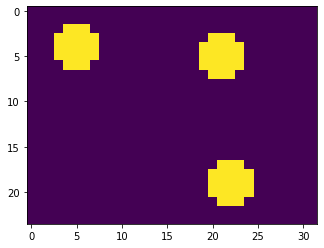

In [9]:
from model_training.training_data_loader import AugmentedBatchesTrainingData

class IrPersonsDataset(torch.utils.data.Dataset):
    def __init__(self, augmented_data: AugmentedBatchesTrainingData, transform=None):
        self.augmented_data = AugmentedBatchesTrainingData
        self.transform = transform
        self._index_to_batch_and_subindex_map = {}
        self._index_to_variance_map = {}

        i = 0
        for b, batch in enumerate(augmented_data.batches):
            frames_in_batch = np.zeros(shape=(len(batch.normalized_ir_data), *batch.normalized_ir_data[0].shape))
            #print(frames_in_batch.shape)
            i0 = i
            
            for j in range(len(batch.normalized_ir_data)):
                self._index_to_batch_and_subindex_map[i] = (batch, j) 
                frames_in_batch[j] = batch.normalized_ir_data[j]
                i += 1
            
            i = i0
            for j in range(len(batch.normalized_ir_data)):
                variance_frames_range = 10
                subframes = frames_in_batch[max(0, j - variance_frames_range):j + variance_frames_range]
                v = np.std(subframes, axis=(0))
                self._index_to_variance_map[i] = v
                i += 1
        
    def __len__(self):
        return len (self._index_to_batch_and_subindex_map)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            raise Exception("Not supported")
            #idx = idx.tolist()

        batch, subindex = self._index_to_batch_and_subindex_map[idx]
        frame = batch.normalized_ir_data[subindex]
        
        batch, subindex = self._index_to_batch_and_subindex_map[idx]
        centre_points = batch.centre_points[subindex]
        img_reconstructed = get_img_reconstructed_from_labels(centre_points)
        img_reconstructed_3d = img_reconstructed
        
        frame_variance = self._index_to_variance_map[idx]
        frame_3d = np.stack((frame, frame_variance))

        return frame_3d, img_reconstructed_3d

    def get_number_of_persons_for_frame(self, idx):
        batch, subindex = self._index_to_batch_and_subindex_map[idx]
        return len(batch.centre_points[subindex])
        
    
    
    
training_dataset = IrPersonsDataset(augmented_data_training)
validation_dataset = IrPersonsDataset(augmented_data_validation)


# it makes no sense to split all data, as most of the frames are almost identical
# training_dataset, validation_dataset = torch.utils.data.random_split(all_data_dataset, [training_data_len, validation_data_len])


trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True)
valloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True)


print(len(trainloader))
print(len(valloader))



train_d1 = trainloader


xb, yb = next(iter(train_d1))
xb.shape, yb.shape


plt.imshow(yb[0].numpy().squeeze())


In [10]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 5, 2)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        #self.conv3 = self.contract_block(64, 128, 3, 1)

        #self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        #conv3 = self.conv3(conv2)

        #upconv3 = self.upconv3(conv3)

        #upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv2 = self.upconv2(conv2)
        
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand
    
    
unet = UNET(2, 2).double()


In [ ]:
# model=unet
# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# params = sum([np.prod(p.size()) for p in model_parameters])
# params

In [ ]:
# model=unet
# sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
unet = unet.to(device)

In [26]:


def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                step += 1
                
                x = x.to(device)
                y = y.to(device)
                
                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()
        
                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                #acc = acc_fn(outputs, y)

                #running_acc  += acc*dataloader.batch_size
                #running_loss += loss*dataloader.batch_size 
                running_loss += loss.item()

                #time.sleep(0.1)
                

                if step % 2000 == 0:
                    # clear_output(wait=True)
                    # print('Current step: {}  Loss: {}  Acc: {}'.format(step, loss, acc))
                    print('Current step: {}  Loss: {}'.format(step, loss))
                    # print(torch.cuda.memory_summary())
                          
            epoch_loss = running_loss / len(dataloader.dataset)
            # epoch_acc = running_acc / len(dataloader.dataset)

            #print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
                          
            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            
            
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    


def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.float().mean())


loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss = train(model=unet, train_dl=train_d1, valid_dl=valloader, 
                               loss_fn=loss_fn, optimizer=opt, acc_fn=acc_metric, epochs=3)



Epoch 0/2
----------
train Loss: 0.0019
Current step: 2000  Loss: 0.03354294436275523
Current step: 4000  Loss: 0.034975741617990726
Current step: 6000  Loss: 0.038161160535912265
Current step: 8000  Loss: 0.03989860032371447
valid Loss: 0.0541
Epoch 1/2
----------
train Loss: 0.0017
Current step: 2000  Loss: 0.03551094682355411
Current step: 4000  Loss: 0.021157808389290742
Current step: 6000  Loss: 0.07635316035070543
Current step: 8000  Loss: 0.031287762611511886
valid Loss: 0.0553
Epoch 2/2
----------
train Loss: 0.0016
Current step: 2000  Loss: 0.03730370387735183
Current step: 4000  Loss: 0.050637737461890785
Current step: 6000  Loss: 0.039876757605558845
Current step: 8000  Loss: 0.04055699807600548
valid Loss: 0.0534
Training complete in 3m 10s


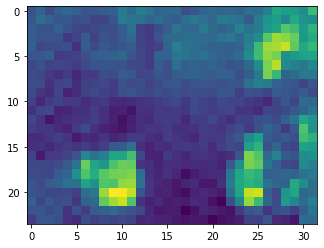

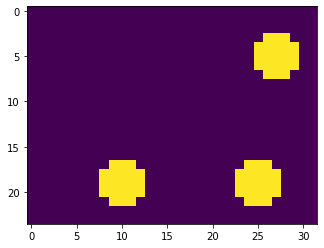

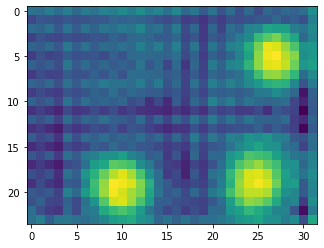

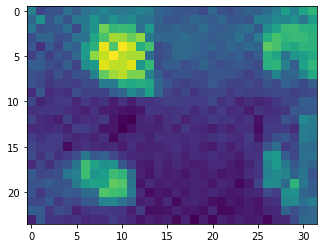

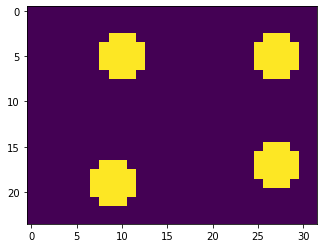

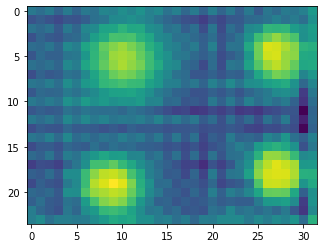

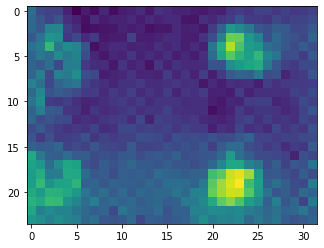

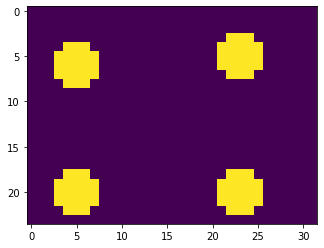

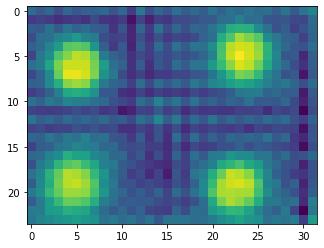

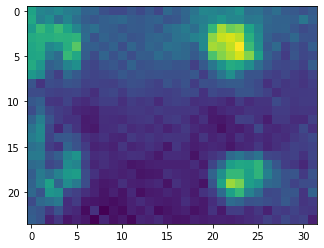

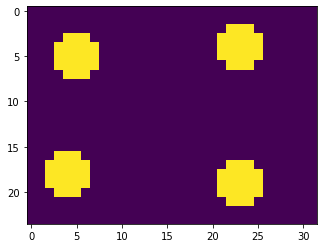

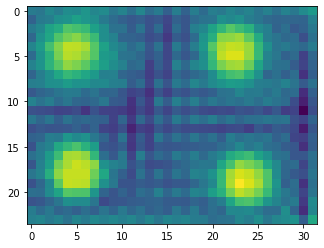

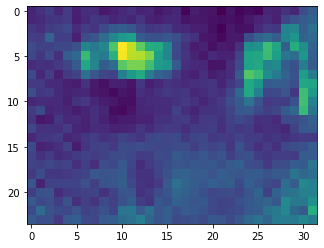

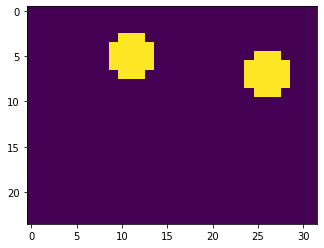

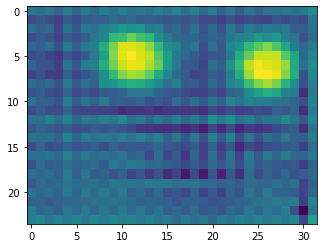

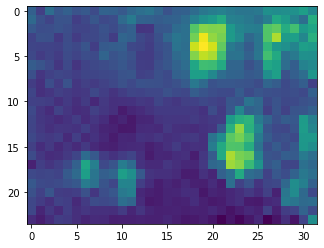

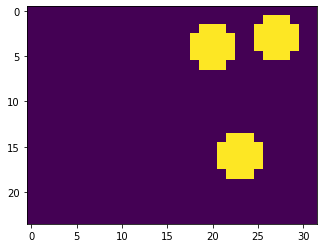

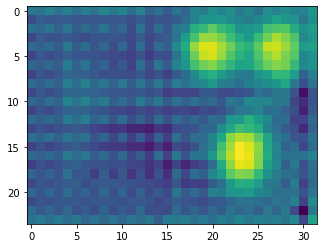

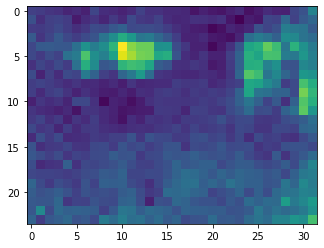

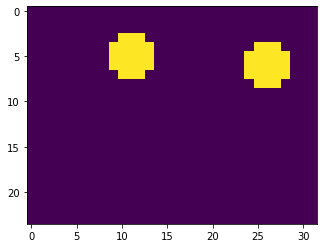

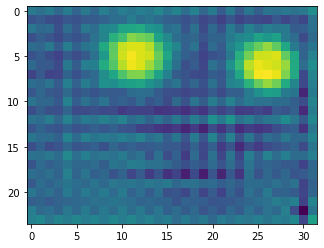

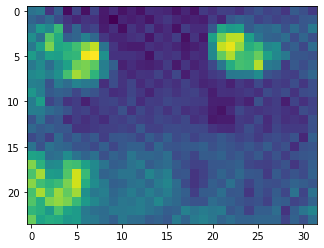

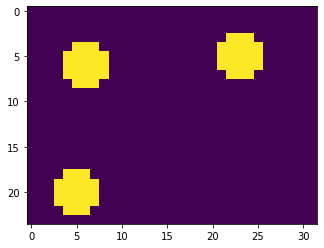

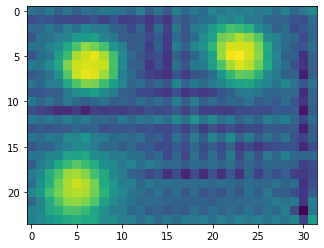

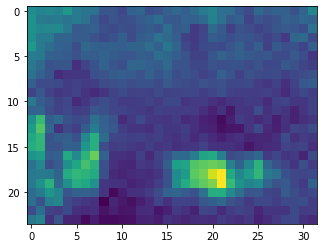

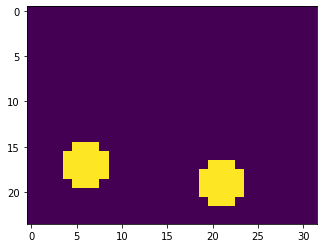

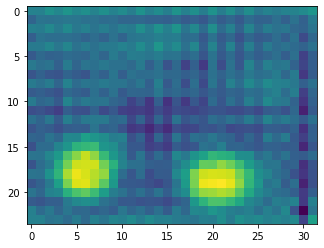

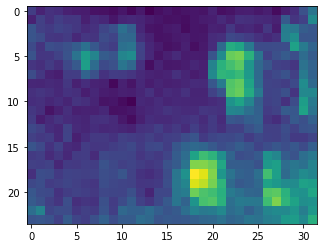

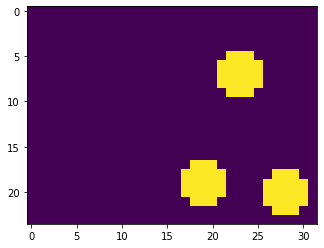

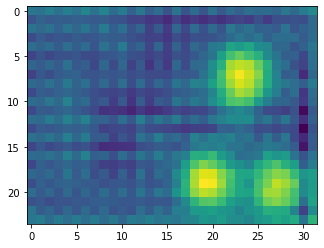

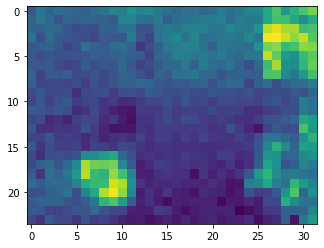

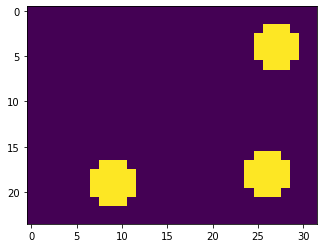

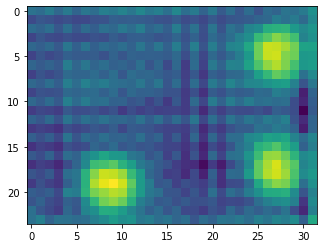

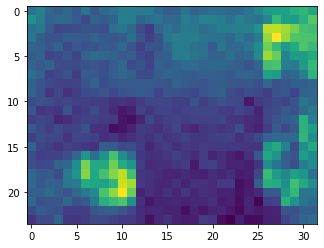

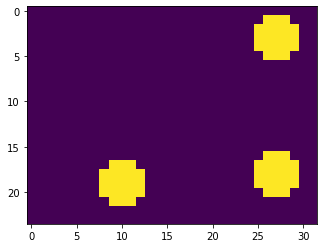

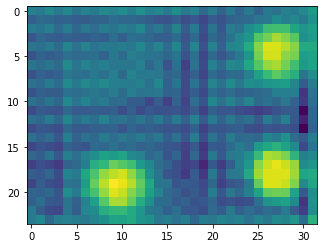

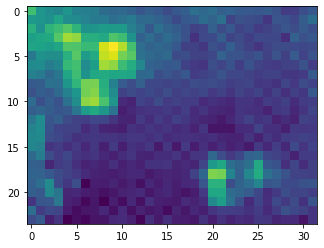

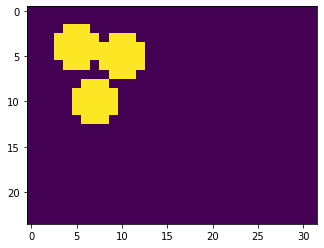

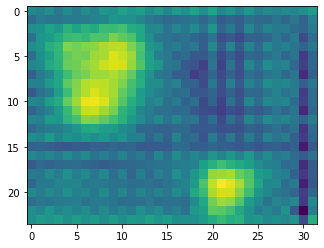

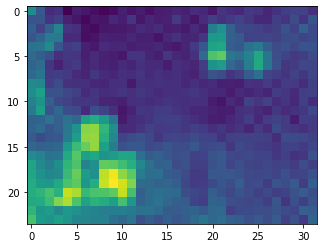

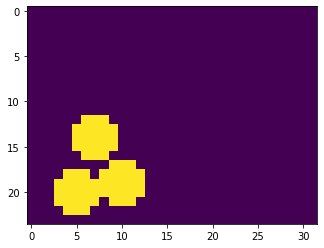

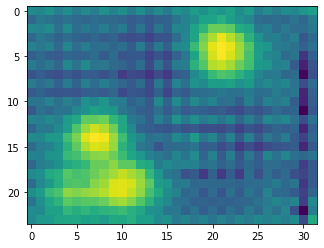

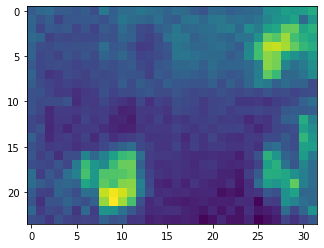

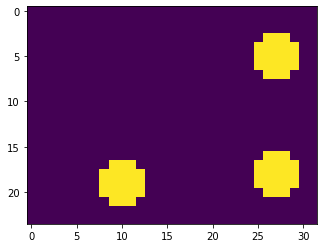

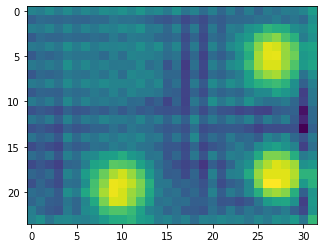

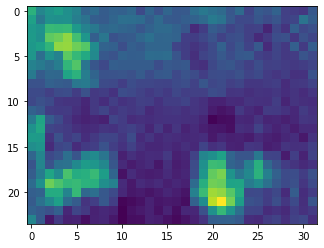

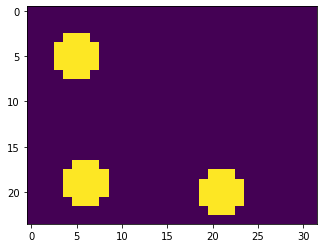

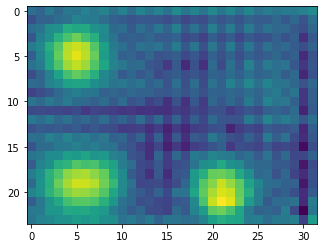

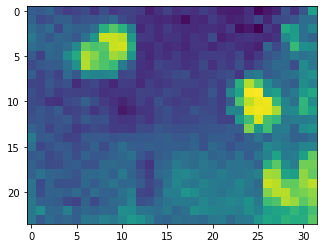

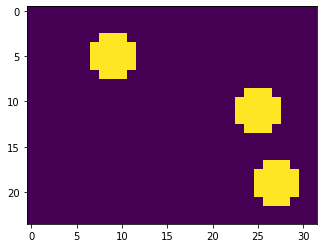

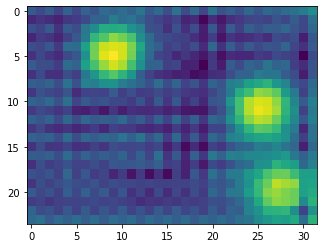

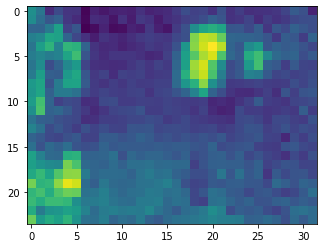

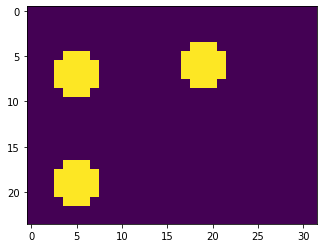

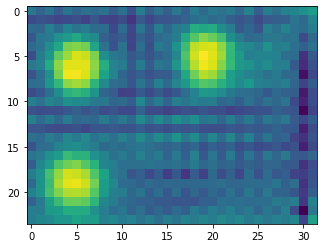

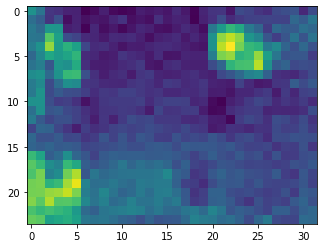

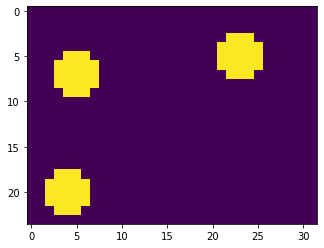

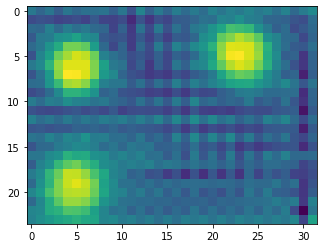

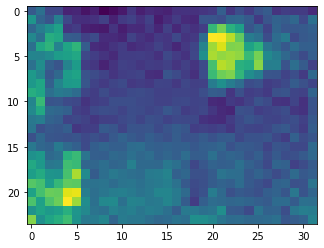

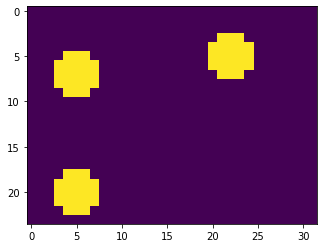

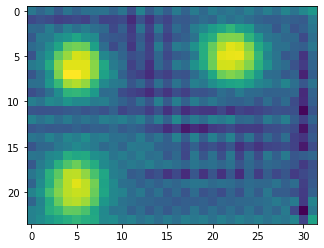

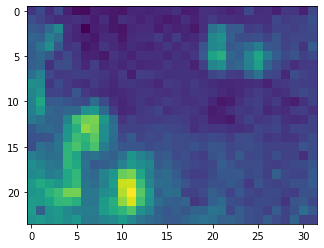

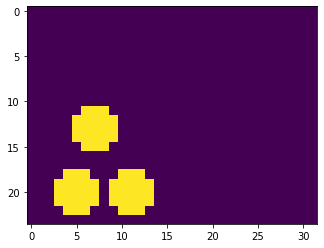

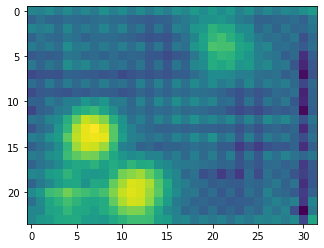

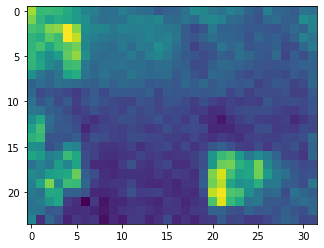

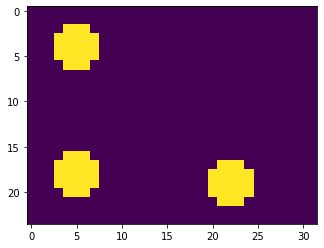

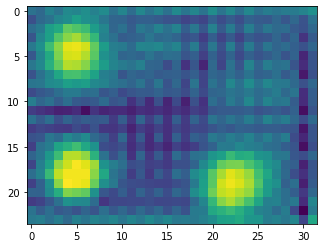

In [27]:
for _ in range(22):
    xb, yb = next(iter(valloader))
    #xb, yb = next(iter(train_d1))
    
    plt.imshow(xb[0][0].numpy().squeeze())
    plt.show()
    plt.imshow(yb[0].numpy().squeeze())
    plt.show()

    with torch.no_grad():
        outputs = unet(xb.to(device)).to(cpu_device)

    for i in range(1, NUMBER_OF_OUPUT_CLASSES):
        plt.imshow(outputs[0,i])
        plt.show()
    print("======================================")

In [28]:
# outputs[0,1]

In [29]:
from model_training.training_data_loader import AugmentedBatchesTrainingData

class IrPersonsDatasetAfterUnet(torch.utils.data.Dataset):
    def __init__(self, unet_model, unet_dataset):
        self.unet_model = unet_model
        self._unet_outputs = {}
        self._unet_dataset = unet_dataset
                
    def __len__(self):
        return len (self._unet_dataset)

    def __getitem__(self, idx):
        if idx not in self._unet_outputs:
            
            unet_input, _ = self._unet_dataset[idx]
            unet_input = unet_input[np.newaxis, :, :, :]
            unet_input = torch.from_numpy(unet_input)
            with torch.no_grad():
                outputs = self.unet_model(unet_input.to(device))
            unet_output = outputs[0,1][np.newaxis, :, :]
            self._unet_outputs[idx] = unet_output
        
        return self._unet_outputs[idx], self._unet_dataset.get_number_of_persons_for_frame(idx)

    
    
training_datase_after_unet = IrPersonsDatasetAfterUnet(unet, training_dataset)
validation_dataset_after_unet = IrPersonsDatasetAfterUnet(unet, validation_dataset)

# it makes no sense to split all data, as most of the frames are almost identical
# training_dataset, validation_dataset = torch.utils.data.random_split(all_data_dataset, [training_data_len, validation_data_len])

trainloader_after_unet = torch.utils.data.DataLoader(training_datase_after_unet, batch_size=16, shuffle=True)
valloader_after_unet = torch.utils.data.DataLoader(validation_dataset_after_unet, batch_size=1, shuffle=True)

print(len(trainloader_after_unet))
print(len(valloader_after_unet))


1648
9420


In [30]:
images, labels = next(iter(valloader_after_unet))
images.shape

torch.Size([1, 1, 24, 32])

torch.Size([16, 1, 24, 32])
torch.Size([16])
Persons: 1


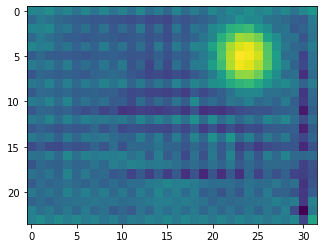

In [31]:
MAX_PEOPLE_TO_COUNT = 5

class ModelSingleFrame1(nn.Module):
    def __init__(self):
        super().__init__()
        
        conv2_out_channels = 32
        l1_in_features = config.IR_CAMERA_RESOLUTION_X * config.IR_CAMERA_RESOLUTION_Y // ((2*2)**2) \
            * conv2_out_channels
        l1_out_features = 128
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=conv2_out_channels, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(in_features=l1_in_features, out_features=l1_out_features)
        self.l2 = nn.Linear(in_features=l1_out_features, out_features=MAX_PEOPLE_TO_COUNT+1)
        
        self.l1_in_features = l1_in_features
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, self.l1_in_features)
        x = F.relu(self.l1(x))
        x = F.dropout(x, p=0.2)
        x = F.log_softmax(self.l2(x), dim=1)
        return x

    
model_conv_1 = ModelSingleFrame1()
model = model_conv_1.double()



dataiter = iter(trainloader_after_unet)
unet_frmaes, labels = dataiter.next()
print(unet_frmaes.shape)
print(labels.shape)

ir_frame_normalized_0 = unet_frmaes[0].to(cpu_device).numpy().squeeze()
plt.imshow(ir_frame_normalized_0)
print(f'Persons: {labels[0]}')

#print(ir_frame_normalized_0)
#print(np.min(ir_frame_normalized_0))

In [32]:
model = model.to(device)

In [33]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader_after_unet))
# print(images.type())
# print(images.shape)

logps = model(images) #log probabilities
loss = criterion(logps, labels.to(device)) #calculate the NLL loss

In [40]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time.time()
epochs = 6

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader_after_unet:    
        # Training pass
        optimizer.zero_grad()
        #print(max(labels))
        output = model(images.to(device))
        loss = criterion(output, labels.to(device))
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader_after_unet)))
        print("\nTraining Time (in minutes) =",(time.time()-time0)/60)

Epoch 0 - Training loss: 0.02297631509151694

Training Time (in minutes) = 0.07138867378234863
Epoch 1 - Training loss: 0.02160838165803598

Training Time (in minutes) = 0.1427473227183024
Epoch 2 - Training loss: 0.020023446593258717

Training Time (in minutes) = 0.21186572313308716
Epoch 3 - Training loss: 0.01867597036802456

Training Time (in minutes) = 0.28063303232192993
Epoch 4 - Training loss: 0.01962288999380309

Training Time (in minutes) = 0.3492020606994629
Epoch 5 - Training loss: 0.01907467295946526

Training Time (in minutes) = 0.4178560217221578


In [41]:
correct_count = 0
tested_frames = 0
number_of_frames_with_n_persons = {}
number_of_frames_with_n_persons_predicted_correctly = {}

for frame, labels in valloader_after_unet:
    for i in range(len(labels)):
        with torch.no_grad():
            logps = model(frame.to(device)).to(cpu_device)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    
    number_of_frames_with_n_persons[pred_label] = \
        number_of_frames_with_n_persons.get(pred_label, 0) + 1
    
    if true_label == pred_label:
        correct_count += 1
        number_of_frames_with_n_persons_predicted_correctly[pred_label] = \
            number_of_frames_with_n_persons_predicted_correctly.get(pred_label, 0) + 1
    
    tested_frames += 1
    

print(f"Number of tested frames: {tested_frames}")
print(f"Model Accuracy = {correct_count / tested_frames}")
print('Predicted:\n' + '\n'.join([f'   {count} frames with {no} persons' for no, count in number_of_frames_with_n_persons.items()]))
print('Predicted correctly:\n' + '\n'.join([f'   {count} frames with {no} persons' for no, count in number_of_frames_with_n_persons_predicted_correctly.items()]))

Number of tested frames: 9420
Model Accuracy = 0.8153927813163482
Predicted:
   2891 frames with 2 persons
   5337 frames with 3 persons
   1191 frames with 4 persons
   1 frames with 1 persons
Predicted correctly:
   1820 frames with 2 persons
   5237 frames with 3 persons
   624 frames with 4 persons
